Original Distribution:
multiclass_label
not_cyberbullying    10000
ethnicity/race        3400
gender/sexual         3400
religion              3198
Name: count, dtype: int64
multiclass_label
not_cyberbullying    50.005001
ethnicity/race       17.001700
gender/sexual        17.001700
religion             15.991599
Name: proportion, dtype: float64

After undersampling distribution:
multiclass_label
not_cyberbullying    90.909091
ethnicity/race        3.030303
gender/sexual         3.030303
religion              3.030303
Name: proportion, dtype: float64
=== Classification Report: Binary ===
                   precision    recall  f1-score   support

not_cyberbullying       1.00      1.00      1.00      9000
    cyberbullying       0.99      0.99      0.99       900

         accuracy                           1.00      9900
        macro avg       0.99      0.99      0.99      9900
     weighted avg       1.00      1.00      1.00      9900

=== Confusion Matrix: Binary ===


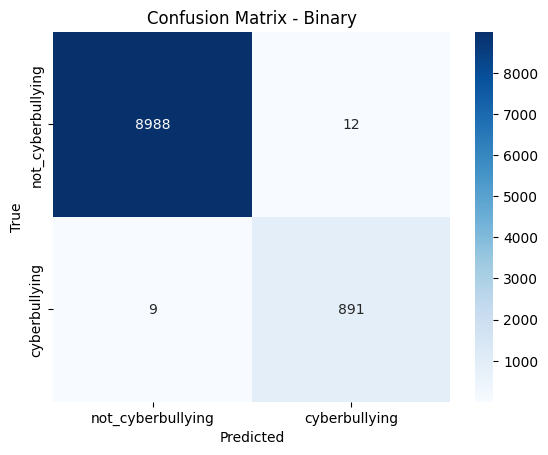

=== Classification Report: Multiclass (only true positives) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       299
         1.0       1.00      0.99      0.99       300
         2.0       1.00      1.00      1.00       292

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891

=== Confusion Matrix: Multiclass (only true positives) ===


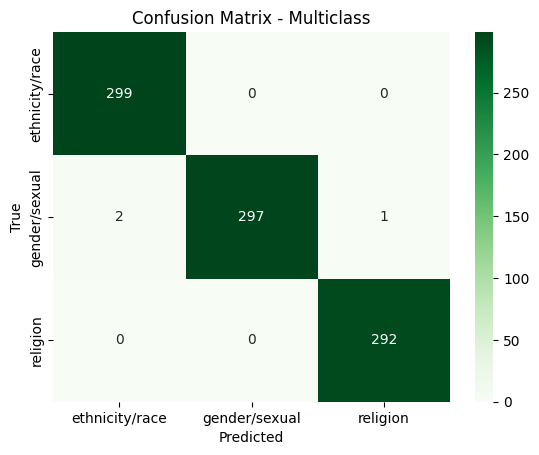

=== Overall Accuracy (binary + multiclass chaining) ===
Correct: 9876 over 9900 = 0.9976


In [9]:
import pandas as pd
from sklearn.utils import resample
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import TextPreprocessor

df_test = pd.read_csv("../dataset/test_set.csv")

print("Original Distribution:")
print(df_test["multiclass_label"].value_counts())
print(df_test["multiclass_label"].value_counts(normalize=True) * 100)

target_total = 10000
n_majority = int(target_total * 0.90)
n_minority = int(target_total * 0.03)

df_majority = df_test[df_test["multiclass_label"] == "not_cyberbullying"]
df_minority_1 = df_test[df_test["multiclass_label"] == "ethnicity/race"]
df_minority_2 = df_test[df_test["multiclass_label"] == "gender/sexual"]
df_minority_3 = df_test[df_test["multiclass_label"] == "religion"]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_majority, random_state=42)
df_minority_1_downsampled = resample(df_minority_1, replace=False, n_samples=n_minority, random_state=42)
df_minority_2_downsampled = resample(df_minority_2, replace=False, n_samples=n_minority, random_state=42)
df_minority_3_downsampled = resample(df_minority_3, replace=False, n_samples=n_minority, random_state=42)

df_test_balanced = pd.concat([
    df_majority_downsampled,
    df_minority_1_downsampled,
    df_minority_2_downsampled,
    df_minority_3_downsampled
])

df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter undersampling distribution:")
print(df_test_balanced["multiclass_label"].value_counts(normalize=True) * 100)

X_test_text = df_test_balanced["text"]
df_train = pd.read_csv("../dataset/training_set.csv")
df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}

y_test_binary = df_test_balanced["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values
y_test_multiclass = df_test_balanced["multiclass_label"].map(label2id)

# === Load trained pipelines ===
file_binary = "../model/binary/RandomForest_TF-IDF.pkl"
file_multiclass = "../model/multiclass/RandomForest_TF-IDF_multiclass.pkl"
clf_binary = joblib.load(file_binary)
clf_multiclass = joblib.load(file_multiclass)

# === Prediction: Binary ===
y_pred_binary = clf_binary.predict(X_test_text)
print("=== Classification Report: Binary ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=["not_cyberbullying", "cyberbullying"]))

print("=== Confusion Matrix: Binary ===")
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=["not_cyberbullying", "cyberbullying"],
            yticklabels=["not_cyberbullying", "cyberbullying"])
plt.title("Confusion Matrix - Binary")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Prediction: Multiclass on TP ===
true_positive_mask = (y_test_binary == 1) & (y_pred_binary == 1)
X_test_text_tp = X_test_text[true_positive_mask]
y_test_multiclass_tp = y_test_multiclass[true_positive_mask]
y_pred_multiclass = clf_multiclass.predict(X_test_text_tp)

print("=== Classification Report: Multiclass (only true positives) ===")
print(classification_report(y_test_multiclass_tp, y_pred_multiclass))

print("=== Confusion Matrix: Multiclass (only true positives) ===")
cm_multi = confusion_matrix(y_test_multiclass_tp, y_pred_multiclass)
labels_multi = ['ethnicity/race', 'gender/sexual', 'religion']
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_multi, yticklabels=labels_multi)
plt.title("Confusion Matrix - Multiclass")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Overall system accuracy ===
true_negative = ((y_test_binary == 0) & (y_pred_binary == 0)).sum()
true_positive_multiclass = (y_pred_multiclass == y_test_multiclass_tp).sum()
total_test_samples = len(y_test_binary)
overall_correct = true_negative + true_positive_multiclass
overall_accuracy = overall_correct / total_test_samples

print(f"=== Overall Accuracy (binary + multiclass chaining) ===")
print(f"Correct: {overall_correct} over {total_test_samples} = {overall_accuracy:.4f}")
